### Analysis Goal

Understanding ad distribution differences between users now that we have 18000+ annotations, how does the bar chart from the ConPro paper look right now? How is distribution changing by demographic group now?

- Build overall distribution plot
- Build by demographic distribution plot
- Build Lorenz curve for full dataset

In [2]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Helvetica"

In [213]:
from collections import defaultdict

def count_code_props(codes, norm=True):
    # takes dict from adid -> codes and returns dict of code proportions
    counts = defaultdict(lambda: 0)
    for aid in codes:
        # in case of multiple codes, count each one -- essentially computing fraction of codes and not ads here
        for code in codes[aid].split(';'):
            if "Can't determine" not in code and code != 'Study':
                counts[code] += 1
                
    if norm:
        return {c: counts[c]/sum(counts.values()) for c in counts}
    else:
        return counts

In [120]:
pid_adid_files = ['../../db-processing/surveys/survey-1/survey1_coding_subsample.tsv',
                  '../../db-processing/surveys/survey-1/survey1_batch2_coding_subsample.tsv',
                 '../../db-processing/surveys/survey-2/survey2_coding_subsample.tsv',
                 '../../db-processing/surveys/survey-3/survey3_coding_subsample.tsv']

pid_adid = pd.read_csv(pid_adid_files[0], sep='\t')
for f in pid_adid_files[1:]:
    pid_adid = pd.concat([pid_adid, pd.read_csv(f, sep='\t')], ignore_index=True)

pids = set(pid_adid['pid'])
part_ad_counts = pid_adid.groupby('pid').count().to_dict()['adid']

codes_file = '../../db-processing/ad_codes.tsv'
codes = pd.read_csv(codes_file, sep='\t')

In [92]:
pid_adid.shape

(20924, 2)

**Mystery**: Why are pid_adids more than codes in the DB??
**Answer**: Survey 4 isn't annotated yet, so not in the codes file

In [214]:
# Count frequency of codes by participants
part_code_props = {}
part_code_counts = {}

for pid in pids:
    joiner = pid_adid[pid_adid['pid'] == pid]
    joined = joiner.merge(codes, how='inner', left_on='adid', right_on='adid')
    
    code_props = count_code_props(dict(joined[['adid', 'codes']].values), norm=True)
    part_code_props[pid] = code_props
    
    code_counts = count_code_props(dict(joined[['adid', 'codes']].values), norm=False)
    part_code_counts[pid] = code_counts

In [122]:
from math import sqrt

def normal_bin_conf(p, n, alpha=.95):
    tab = {0.90: 1.645, 0.95: 1.96, 0.99: 2.58}
    z = tab[alpha]
    # binomial proportion confidence interval
    return z * sqrt((p * (1-p))/n)

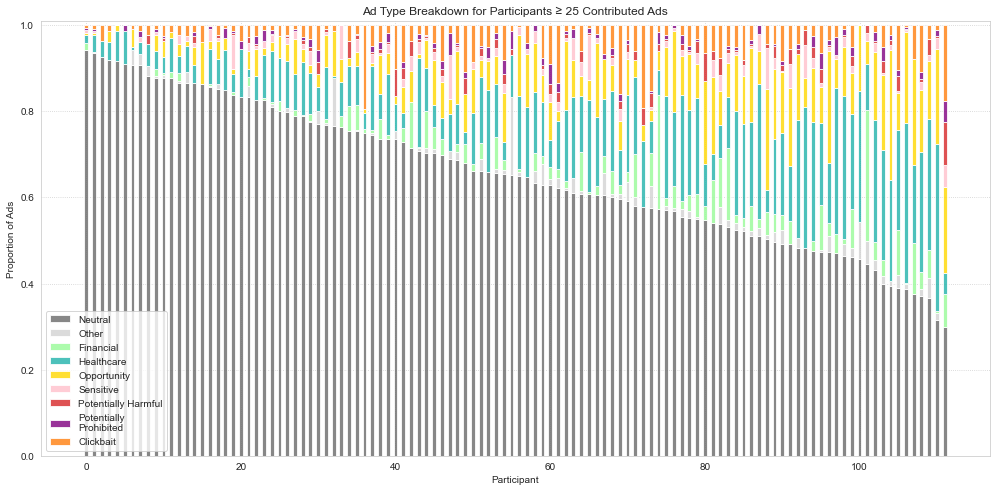

In [324]:
plot_names = {
    'Benign': 'Neutral',
    'Healthcare': 'Healthcare',
    'Opportunity': 'Opportunity',
    'Clickbait': 'Clickbait',
    'Financial': 'Financial',
    'Potentially Harmful': 'Potentially Harmful',
    'Political': 'Political',
    'Potentially Prohibited': 'Potentially\nProhibited',
    'CA Lawsuit': 'Class Action\nLawsuit',
    'Harmful': 'Problematic',
    'Other': 'Other',
    'Sensitive': 'Sensitive'
}

colors = {
    'Benign': 'dimgray',
    'Financial': 'palegreen',
    'Healthcare': 'lightseagreen',
    'Opportunity': 'gold',
    'Harmful': 'tab:red',
    'Potentially Harmful': 'tab:red',
    'Potentially Prohibited': 'purple',
    'Clickbait': 'tab:orange',
    'Sensitive': 'pink',
    'Other': 'lightgray'
}

bar_order = ['Benign', 'Other', 'Financial', 'Healthcare', 'Opportunity', 'Sensitive',
             'Potentially Harmful', 'Potentially Prohibited', 'Clickbait']

# visualize in descending order of fraction benign
part_order = sorted(pids, key=lambda pid: part_code_props[pid].get('Benign', 0), reverse=True)
# exclude participants with < 25 ads
part_order = [p for p in part_order if part_ad_counts[p] >= 25]
f, ax = plt.subplots(figsize=(17, 8))

# total across categories we care about
totals = {p: 0 for p in part_order}
for p in part_order:
    for code in bar_order:
        if code == 'Other':
            totals[p] += part_code_counts[p].get('CA Lawsuit', 0)
            totals[p] += part_code_counts[p].get('Political', 0)
        else:
            totals[p] += part_code_counts[p].get(code, 0)

last = np.zeros(len(part_order))
for code in bar_order:
    if code == 'Other':
        curr = [part_code_props[p].get('CA Lawsuit', 0) + part_code_props[p].get('Political', 0)\
                         for p in part_order]
    else:
        curr = [part_code_props[p].get(code, 0) for p in part_order]
        
#     errs = [normal_bin_conf(curr[i], totals[p]) if (totals[p]*curr[i]) >= 5 else 0 \
#             for i, p in enumerate(part_order)]
    errs = None
    ax.bar(np.arange(len(part_order)), curr, .5, yerr=errs, label=plot_names[code], bottom=last,
           color=colors[code], alpha=.8, ecolor=colors[code])
    last += np.array(curr)
    
ax.set_ylabel('Proportion of Ads')
ax.set_xlabel('Participant')
ax.set_ylim(top=1.01)
ax.grid(ls=':')
ax.legend()
ax.set_title('Ad Type Breakdown for Participants ≥ 25 Contributed Ads')

plt.savefig('ad-type-breakdown.pdf', bbox_inches='tight', dpi=150)

**TODO**: what are the demographics of the people on the far right of this plot?

**Important TODO**: factor in frequency of seeing ad into these analyses.

**Questions**:
- Does clickbait have anything to do with education?
- Does healthcare have to do with gender?

### Demographics comparisons

In [141]:
dems_file = '../../db-processing/participant_dems.tsv'
dems = pd.read_csv(dems_file, sep='\t')

# loading dems from the recruitment file
# dems_file = '../../db-processing/participant-demographics/ALLDEMS.csv'
# dems = pd.read_csv(dems_file, index_col='pid')
# dems.drop_duplicates(inplace=True)
# dems_dict = dems.to_dict(orient='index')

In [158]:
def count_dem_counts(var):
    global dems, pid_adid, codes
    dem_code_props = {}
    dem_code_counts = {}
    
    # compute code proportions for each unique demographic bucket in survey #1 participants
    for bucket in list(dems[var].value_counts().index):
        if bucket == 'no-answer':
            continue

        # find all PIDs that belong to current demographic bucket e.g. 25-34 for age
        bucket_pids = set(dems[dems[var] == bucket]['pid'])

        # find ad IDs and codes corresponding to PIDs found above
        joiner = pid_adid[pid_adid['pid'].isin(bucket_pids)]
        joined = joiner.merge(codes, how='inner', left_on='adid', right_on='adid')
        code_props = count_code_props(dict(joined[['adid', 'codes']].values), norm=True)
        code_counts = count_code_props(dict(joined[['adid', 'codes']].values), norm=False)

        # save bucket-level results
        dem_code_props[bucket] = code_props
        dem_code_counts[bucket] = code_counts
        
    return dem_code_counts, dem_code_props

{'highschool': 2390, 'associate': 1672, 'some-college': 3890, 'college': 7903, 'gradschool': 4672}


Text(0.5, 0.98, 'Difference of ad types by education')

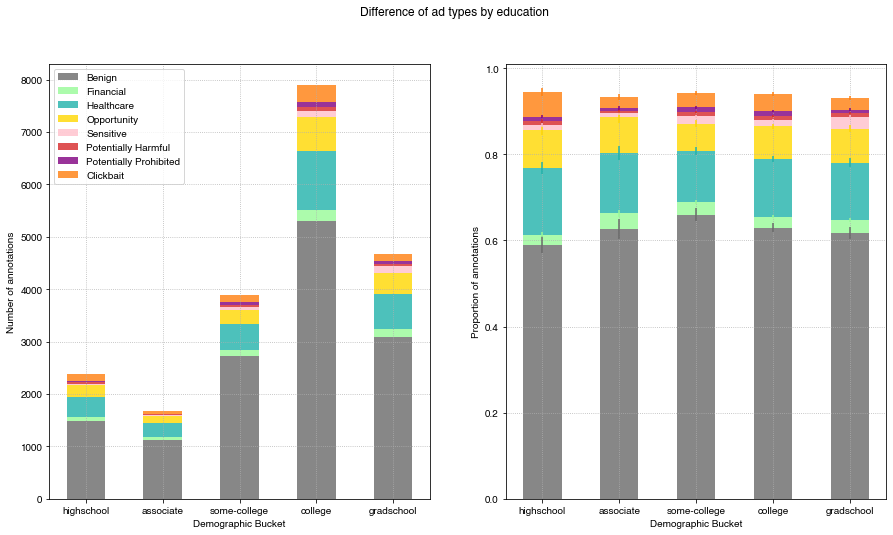

In [162]:
orders = {
    'ethnicity': ['white', 'black', 'hispanic', 'asian'],
    'income': ['under-25k', '25k-50k', '50k-75k', '75k-100k', '100k+'],
    'age': ['18-24', '25-34', '35-44', '45-54'],
    'gender': [1, 2],
    'education': ['highschool', 'associate', 'some-college', 'college', 'gradschool']
}
# compute at demographic and not user-level
dem_code_props = {}
dem_code_counts = {}
var = 'education'

# compute code proportions for each unique demographic bucket in survey #1 participants
for bucket in list(dems[var].value_counts().index):
    if bucket == 'no-answer':
        continue
        
    # find all PIDs that belong to current demographic bucket e.g. 25-34 for age
    bucket_pids = set(dems[dems[var] == bucket]['pid'])
    
    # find ad IDs and codes corresponding to PIDs found above
    joiner = pid_adid[pid_adid['pid'].isin(bucket_pids)]
    joined = joiner.merge(codes, how='inner', left_on='adid', right_on='adid')
    code_props = count_code_props(dict(joined[['adid', 'codes']].values), norm=True)
    code_counts = count_code_props(dict(joined[['adid', 'codes']].values), norm=False)
    
    # save bucket-level results
    dem_code_props[bucket] = code_props
    dem_code_counts[bucket] = code_counts
    
hor_order = orders[var]
bar_order = ['Benign', 'Financial', 'Healthcare', 'Opportunity', 'Sensitive',
             'Potentially Harmful', 'Potentially Prohibited', 'Clickbait']
f, axs = plt.subplots(1, 2, figsize=(15, 8))

# compute totals for CI calculation
totals = {p: 0 for p in hor_order}
for p in hor_order:
    for code in bar_order:
        totals[p] += dem_code_counts[p].get(code, 0)
            
print(totals)

# visuzlize counts
last = np.zeros(len(hor_order))
for code in bar_order:
    curr = [dem_code_counts[b].get(code, 0) for b in hor_order]
        
    axs[0].bar(np.arange(len(hor_order)), curr, .5, label=code, bottom=last,
              color=colors[code], alpha=.8)
    last += np.array(curr)

axs[0].set_ylabel('Number of annotations')
axs[0].legend()
    
# visualize proportions
last = np.zeros(len(hor_order))
for code in bar_order:
    curr = [dem_code_props[b].get(code, 0) for b in hor_order]
        
    errs = [normal_bin_conf(curr[i], totals[p]) if (totals[p]*curr[i]) >= 5 else 0 \
        for i, p in enumerate(hor_order)]
    axs[1].bar(np.arange(len(hor_order)), curr, .5, label=code, bottom=last,
              color=colors[code], alpha=.8, yerr=errs, ecolor=colors[code])
    last += np.array(curr)

axs[1].set_ylabel('Proportion of annotations')
axs[1].set_ylim(top=1.01)
for ax in axs:
    ax.set_xlabel('Demographic Bucket')
    ax.set_xticks(np.arange(len(hor_order)))
    ax.set_xticklabels(hor_order)
    ax.grid(ls=':')
    
# ax.suptitle('Difference of ad types across Survey #1 participants')
plt.suptitle(f'Difference of ad types by {var}')
# plt.savefig(f'{var}-codes-survey-1.jpg', dpi=200, bbox_inches='tight')

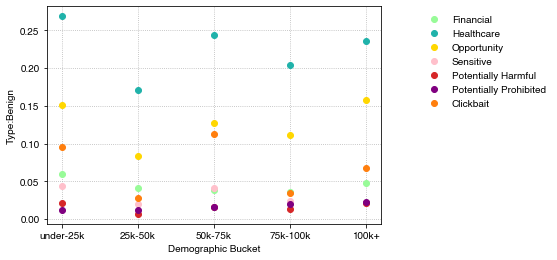

In [172]:
# is the distribution of each code within each group uniform? plot cdf
var = 'income'
dem_counts, props = count_dem_counts(var)

benign_counts = np.array([dem_counts[bucket]['Benign'] for bucket in orders[var]])

for c in bar_order:
    if c != 'Benign':
        # plot ratio with benign
        counts = [dem_counts[bucket][c] for bucket in orders[var]]
        ratios = np.array(counts) / benign_counts
        plt.plot(np.arange(len(ratios)), ratios, color=colors[c], label=c, marker='o', ls='')

plt.legend(frameon=False, bbox_to_anchor=(1.1, 1))
plt.ylabel('Type:Benign')
# plt.set_ylim(top=1.01)
plt.xlabel('Demographic Bucket')
plt.xticks(np.arange(len(orders[var])), orders[var])
# plt.set_xticklabels(orders[var])
plt.grid(ls=':')

### Lorenz Curve

In [334]:
from collections import Counter

plotorder = ['Benign', 'Healthcare', 'Opportunity', 'Clickbait', 'Sensitive',
             'Potentially Prohibited', 'Potentially Harmful', 'Financial']
part_order = sorted(pids, key=lambda pid: part_code_props[pid].get('Benign', 0), reverse=True)

code_counts_local = Counter()
for p in part_order:
    for c in part_code_counts[p]:
        code_counts_local[c] += part_code_counts[p][c]

# compute lorenz curve for each code
lorenz = {}
for c in plotorder:
    # counts of each code's contributions by each user
    counts = np.array([part_code_counts[p].get(c, 0) for p in part_order])
    lorenz[c] = np.cumsum(sorted(counts)) / code_counts_local[c]

Text(0, 0.5, 'Cumulative Fraction of Ads Contributed')

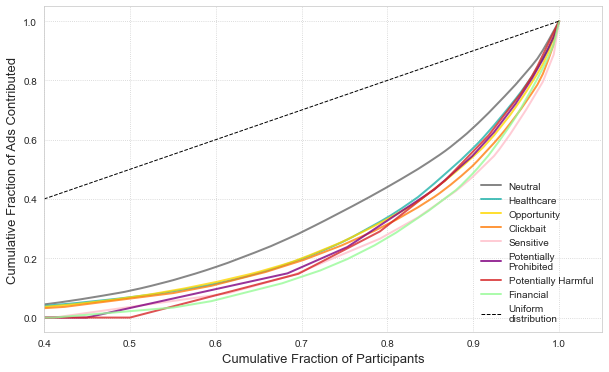

In [342]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))

for c in plotorder:
    # converting participant to "fraction of participants"
    x_trans = np.array(range(len(part_order)))/(len(part_order)-1)
    ax.plot(x_trans, lorenz[c], label=plot_names[c], lw=2, color=colors[c], alpha=.8)

ax.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), ls='--', color='k', lw=1, label='Uniform\ndistribution')
ax.grid(ls=':')
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(left=0.4)
ax.legend(frameon=False)
ax.set_xlabel('Cumulative Fraction of Participants', fontsize=13)
ax.set_ylabel('Cumulative Fraction of Ads Contributed', fontsize=13)

**NOTE**: Sensitive, Financial, Clickbait, and Opportunity (in that order) seem to be the most disparate i.e. these must be present only for a subset of users.

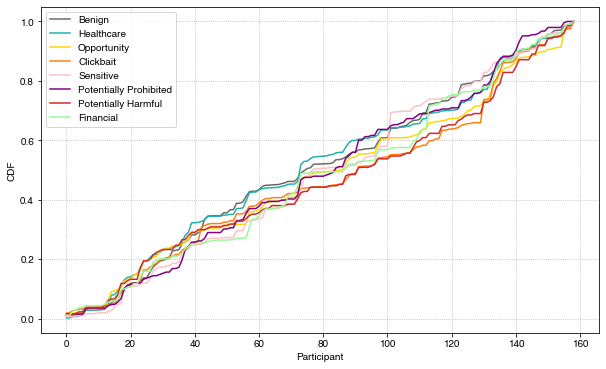

In [220]:
plt.subplots(1, 1, figsize=(10, 6))

for c in plotorder:
    counts = [part_code_counts[pid].get(c, 0) for pid in list(pids)]
    pdf = np.array(counts) / sum(counts)
    plt.plot(np.arange(len(pdf)), np.cumsum(pdf), label=c, color=colors[c])
    
plt.legend()
plt.xlabel('Participant')
plt.ylabel('CDF')
plt.grid(ls=':')

In [279]:
import seaborn as sns

/Users/muhammadali/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

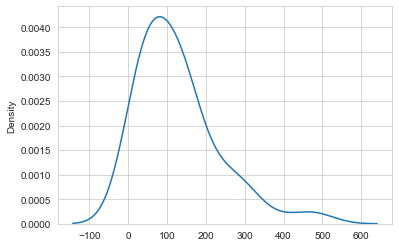

In [283]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(counts), bw=.5, label=c)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


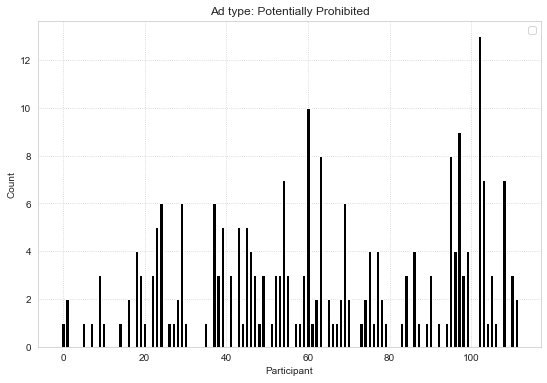

In [332]:
f, ax = plt.subplots(1, 1, figsize=(9, 6))

c = 'Potentially Prohibited'
counts = [part_code_counts[pid].get(c, 0) for pid in part_order]
pdf = np.array(counts) / sum(counts)

# ax.bar(range(len(pdf)), pdf)
ax.bar(range(len(counts)), counts, color='k')
plt.title(f'Ad type: {c}')
plt.xlabel('Participant')
plt.ylabel('Count')
plt.grid(ls=':')
plt.legend()
plt.savefig(f'isolated_{c}.png', bbox_inches='tight')

### Descriptive Demographics

**NOTE**:
In terms of the PDF of participants, is it possible to characterize the users that see a majority of certain content?
- For example, top 5% percentile of finance consumers: what does their debt look like, gender? Just list these things
- Top 5% consumers of "sensitive" content: what are the demographics of these people?

Looking at demographics is a 2 step process: the `dems` dataframe itself, and then other auxiliary questions from the recruitment survey.

In [252]:
dems_file = '../../db-processing/participant-demographics/ALLDEMS.csv'
dems_rec = pd.read_csv(dems_file, index_col='pid')
dems_rec.drop_duplicates(inplace=True)
dems_dict = dems_rec.to_dict(orient='index')

In [266]:
# which people are most susceptible to clickbait ads?
c = 'Clickbait'

for c in ['Clickbait', 'Potentially Harmful', 'Healthcare', 'Financial']:
    print(f'===== {c} =====')
    pids_list = list(pids)
    counts = [part_code_counts[pid].get(c, 0) for pid in pids]
    # who sees the top 20% of this content?
    pdf = np.array(sorted(counts)) / sum(counts)
    pids_ord = np.argsort(pdf)[::-1]   # pid indices in order of highest PDF
    cdf = np.cumsum(pdf)
    top_20_perc = cdf[cdf >= .8]   # i.e. picking up the rightmost end of the Lorenz curve

    for p in pids_ord[:len(top_20_perc)]:
        print('pid:', pids_list[p], 'pdf:', round(pdf[p], 3))
        # show demographics
        print(dems[dems['pid'] == pids_list[p]])

        print('\n')

===== Clickbait =====
pid: 60ee4077cdf4f24a1c607783 pdf: 0.078
                        pid    age     income   education ethnicity
3  60ee4077cdf4f24a1c607783  45-54  under-25k  gradschool     black


pid: 614254 pdf: 0.052
        pid    age     income   education ethnicity
101  614254  25-34  under-25k  highschool     white


pid: 326424 pdf: 0.048
        pid    age     income   education ethnicity
169  326424  25-34  under-25k  gradschool     white


pid: 340465 pdf: 0.036
       pid    age income   education ethnicity
88  340465  35-44  100k+  gradschool     white


===== Potentially Harmful =====
pid: 60ee4077cdf4f24a1c607783 pdf: 0.038
                        pid    age     income   education ethnicity
3  60ee4077cdf4f24a1c607783  45-54  under-25k  gradschool     black


pid: 326424 pdf: 0.038
        pid    age     income   education ethnicity
169  326424  25-34  under-25k  gradschool     white


pid: 340465 pdf: 0.038
       pid    age income   education ethnicity
88  340465  